## 1.3 Concatenate and visualize


We have downloaded 175 netcdf files, that we will compile into one netcdf file here. Also we will plot the modeled and observed precipitation.

### Import packages

In [90]:
##This is so variables get printed within jupyter
from IPython.core.interactiveshell import InteractiveShell 
InteractiveShell.ast_node_interactivity = "all"

In [91]:
##import packages
import os
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs


In [4]:
##We want the working directory to be the UNSEEN-open directory
pwd = os.getcwd() ##current working directory is UNSEEN-open/Notebooks/1.Download
pwd #print the present working directory
os.chdir(pwd+'/../../') # Change the working directory to UNSEEN-open
os.getcwd() #print the working directory

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open/Notebooks/1.Download'

'/lustre/soge1/projects/ls/personal/timo/UNSEEN-open'

## Concatenate

Here we will create an netcdf file that contains the dimensions lat, lon, number (25 ensembles), time (35 years) and leadtime (5 initialization months). We loop over lead times, and open all 35 years of the lead time and then concatenate those leadtimes. 

In [22]:
init_months = np.append(np.arange(9,13),1) ## Initialization months 9-12,1 (Sep-Jan)


array([ 1, 12, 11, 10,  9])

In [43]:
SEAS5_ld1= xr.open_mfdataset('../UK_example/' + '*01.nc', combine='by_coords') # Load the first lead time 
SEAS5= SEAS5_ld1 # Create the xarray dataset to concatenate over
for init_month in init_months[0:-1][::-1]: ## Remove the first that we already have and invert so it is lead time 1-5
    print(init_month)
    SEAS5_ld = xr.open_mfdataset('../UK_example/' + '*' +  "%.2i" % init_month + '.nc', combine='by_coords') # Load the first lead time to concatenate over
    SEAS5=xr.concat([SEAS5,SEAS5_ld],dim='leadtime') 


12
11
10
9


In [87]:
SEAS5 = SEAS5.assign_coords(leadtime = np.arange(5) + 1) # assign leadtime coordinates
SEAS5['tprate'] = SEAS5['tprate'] * 1000 * 3600 * 24 ## From m/s to mm/d
SEAS5['tprate'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}

## Visualize

I first open EOBS historical precipitation from knmi through opendap. This is EOBS v17, running from 1950 - 2017. I will select February monthly mean precipitation to compare to SEAS5.

In [72]:
EOBS = xr.open_dataset('http://opendap.knmi.nl/knmi/thredds/dodsC/e-obs_0.50regular/rr_0.50deg_reg_v17.0.nc')
# Concatenated_file.groupby("time.month").mean(dim=['start','ensemble',"time"])
EOBS = EOBS.sel(time=EOBS['time.month'] == 2) ## Select only February
EOBS = EOBS.groupby("time.year").mean('time') ## And calculate the monthly mean precipitation

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


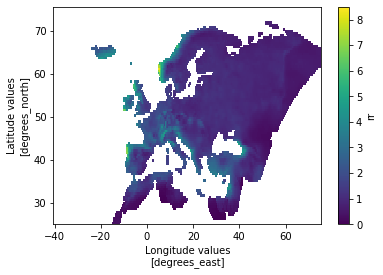

In [81]:
EOBS['rr'].attrs = {'long_name': 'rainfall',
 'units': 'mm/day',
 'standard_name': 'thickness_of_rainfall_amount'}
EOBS['rr'].mean('year').plot()

/soge-home/users/cenv0732/.conda/envs/UNSEEN-open/lib/python3.8/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)


Text(0.5, 1.0, 'SEAS5')

Text(0.5, 1.0, 'EOBS')

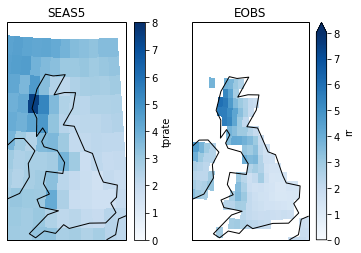

In [89]:
fig, axs = plt.subplots(1, 2,subplot_kw={'projection': ccrs.OSGB()})

SEAS5['tprate'].mean(dim = ['time','leadtime','number']).plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[0])  #,cmap=plt.cm.Blues,
EOBS['rr'].mean('year').plot(transform=ccrs.PlateCarree(), vmin = 0, vmax = 8, cmap=plt.cm.Blues, ax=axs[1])

for ax in axs.flat:
    ax.coastlines(resolution='110m')
    
axs[0].set_title('SEAS5')
axs[1].set_title('EOBS')